In [1]:
# Load Wine dataset
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [2]:
# break data into 70/30 split and standardize to unit variance
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
# construct covariance matrix
import numpy as np
cov_mat = np.cov(X_train_std.T)

# obtain eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenValues \n', eigen_vals)


EigenValues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


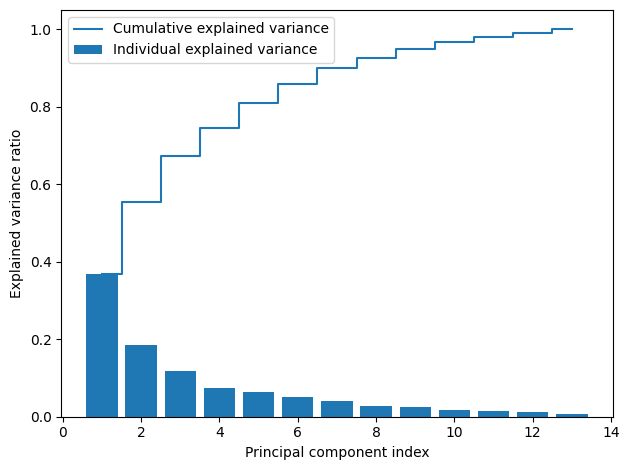

In [4]:
# plot variance explained ratios of eigenvalues (fraction of eigenvalue and total sum of eigenvalues)
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, align='center', label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
# 1. sort eigenpairs is descending order of eigen values
# 2. construction projection matrix from selected eigenvectors
# 3. use projection matrix to transform data onto lower-dimensional subspace

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [6]:
# select top two eigenvectors
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [7]:
# project matrix to new subspace
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [8]:
# transform entire training dataset using 2 PCA
X_train_pca = X_train_std.dot(w)


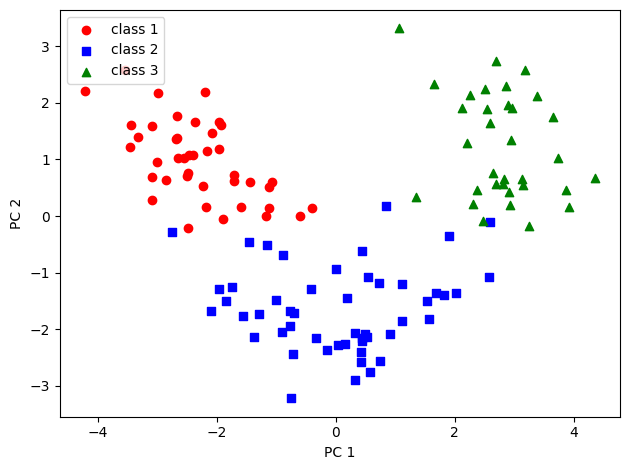

In [9]:
# visualize training dataset (now 124x2) on new subspace
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=f'class {l}', marker=m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ( 'o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid( np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict( np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter( x=X[y == cl, 0],
                     y=X[y == cl, 1],
                     alpha=0.8,
                     c=colors[idx],
                     marker=markers[idx],
                     label=f'Class {cl}',
                     edgecolor='black')

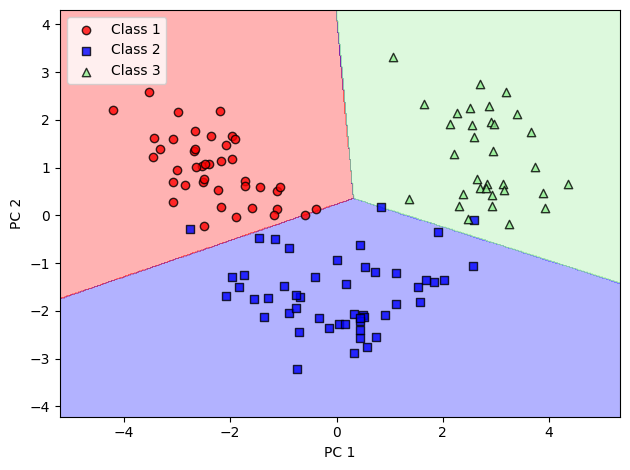

In [11]:
# Use sklearn PCA
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# intializing the PCA transformer and logistic regression estimator
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')

# dimensionality reduction
X_train_pca = pca.fit_transform( X_train_std )
X_test_pca = pca.transform(X_test_std)

# fitting logistic regression model on the reduced dataset
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


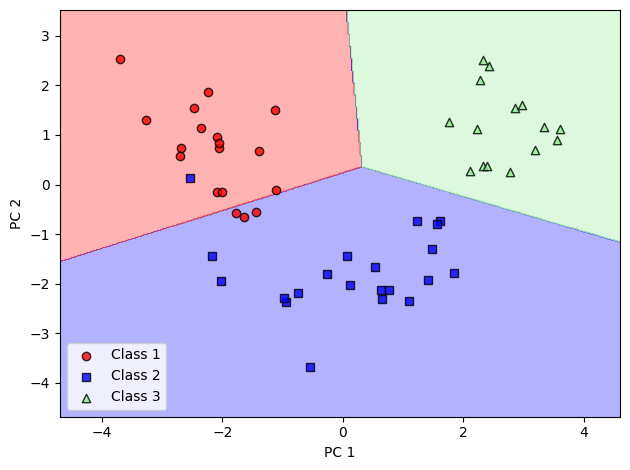

In [12]:
# plot decision region of logistic regression on transformed data set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [13]:
# show explained variance ratios for all PCA
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [14]:
# computing loadings matrix, where loadings are how much each
# original feature contributes to a given principal component
loadings = eigen_vecs * np.sqrt(eigen_vals)

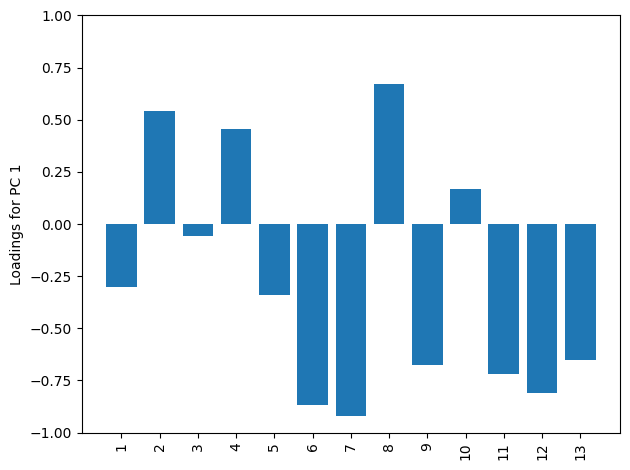

In [17]:
# plot loadings for first PC which is first column of matrix
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

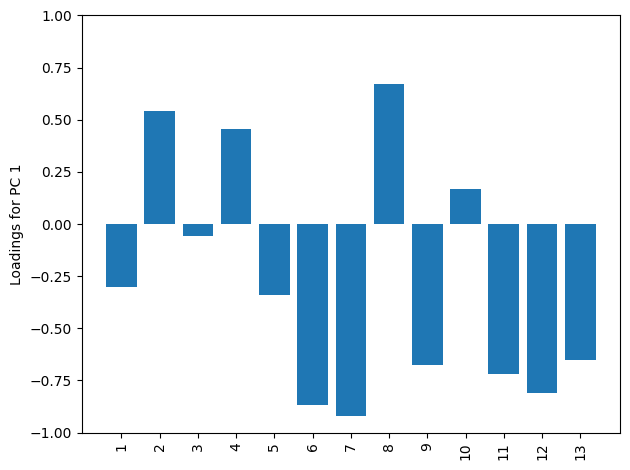

In [18]:
# obtain loadings for fitted sklearn PCA object
sklearn_loadings = pca.components_.T * np.sqrt( pca.explained_variance_ )

fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## Linear Discriminant Analysis

In [21]:
# 1. Standardize dataset (already done)
# 2. compute mean vector
np.set_printoptions(precision=4)
mean_vecs = []

for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print(f'MV {label}: {mean_vecs[label-1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [22]:
# 3. compute between class scatter matrix and within-class scatter matrix
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: ', f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix:  13x13


In [26]:
# violates assumption that training dataset normally distributed
print('Class label distribution', np.bincount(y_train[1:]))

Class label distribution [ 0 41 50 32]


In [29]:
# compute scaled with-class scatter matrix (which is same as computing covariance matrix)
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs ):
    class_scatter = np.cov( X_train_std[y_train==label].T )
    S_W += class_scatter
print('Scaled within-class scatter-matrix: ', f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter-matrix:  13x13


In [30]:
# Compute between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

d = 13 # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: ', f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix:  13x13


In [31]:
# 4. Compute eigenvectors and eigenvalues

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [33]:
# 5. sort eigenvector eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order
349.61780890599397
172.7615221897938
3.176506162325064e-14
2.842170943040401e-14
2.524076602752609e-14
2.524076602752609e-14
1.7104020034602083e-14
1.7104020034602083e-14
1.5400541441701068e-14
1.4529863140519795e-14
4.66036996010505e-15
4.66036996010505e-15
4.529165348731398e-15


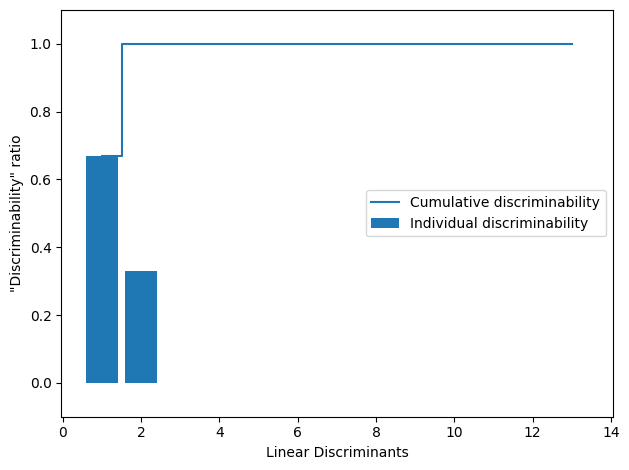

In [35]:
# plot linear discriminants by decreasing eigenvalues
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, align='center', label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative discriminability')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [36]:
# 6. construct transformation matrix using two most discriminative eigenvector columns
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


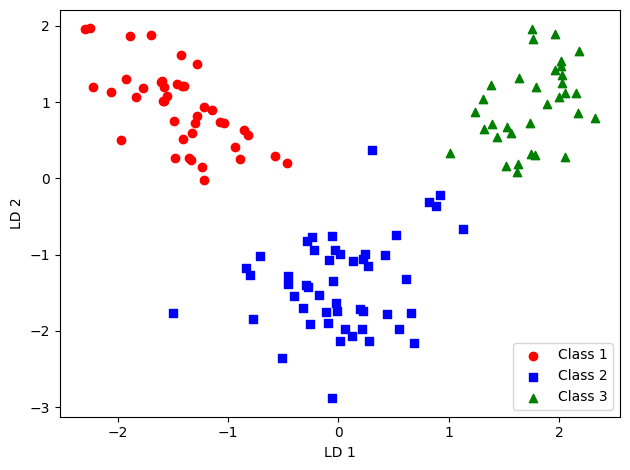

In [38]:
# 7. Project examples onto new feature space
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1] * (-1), 
                c=c, label=f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [39]:
# LDA in scikit learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

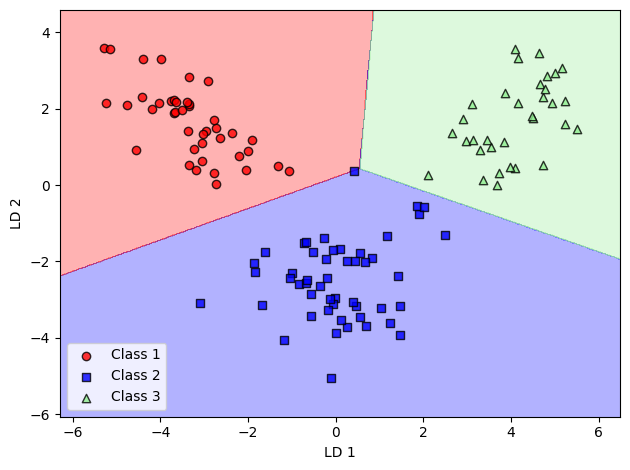

In [40]:
# test logistic regression classifier with lower dimensional training dataset after LDA transformation
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

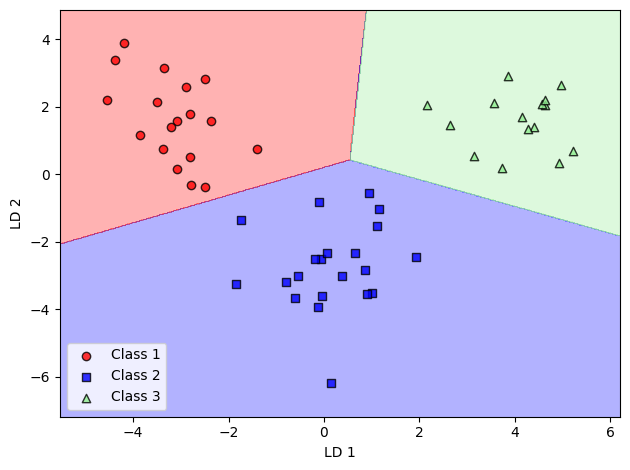

In [41]:
# results on test dataset
x_test_lda = lda.transform(X_test_std)
plot_decision_regions(x_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()